In [1]:
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_selector as selector
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

In [2]:
adult_census = pd.read_csv("datasets/adult-census.csv")

target_column = "class"
target = adult_census[target_column]

data = adult_census.drop(columns=[target_column, "education-num"])
data.head()

,age,workclass,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,25,Private,11th,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States
1,38,Private,HS-grad,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States
2,28,Local-gov,Assoc-acdm,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States
3,44,Private,Some-college,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States
4,18,?,Some-college,Never-married,?,Own-child,White,Female,0,0,30,United-States


In [3]:
X_train, X_test, y_train, y_test = train_test_split(data, target, random_state=42)

In [4]:
categorical_columns_selector = selector(dtype_include=object)
categorical_columns = categorical_columns_selector(data)

categorical_preprocessor = OrdinalEncoder(
    handle_unknown="use_encoded_value", unknown_value=-1
)

preprocessor = ColumnTransformer(
    [("cat_preprocessor", categorical_preprocessor, categorical_columns)],
    remainder="passthrough",
)

model = Pipeline(
    [
        ("preprocessor", preprocessor),
        (
            "classifier",
            HistGradientBoostingClassifier(random_state=42, max_leaf_nodes=4),
        ),
    ]
)
model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat_preprocessor',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['workclass', 'education',
                                                   'marital-status',
                                                   'occupation', 'relationship',
                                                   'race', 'sex',
                                                   'native-country'])])),
                ('classifier',
                 HistGradientBoostingClassifier(max_leaf_nodes=4,
                                                random_state=42))])

In [5]:
param_grid = {
    "classifier__learning_rate": (0.01, 0.1, 1, 10),
    "classifier__max_leaf_nodes": (3, 10, 30),
}

model_grid_search = GridSearchCV(model, param_grid=param_grid, n_jobs=2, cv=2)

model_grid_search.fit(X_train, y_train)
accuracy = model_grid_search.score(X_test, y_test)
print(f"The test accuracy score of the grid-searched pipeline is: {accuracy:.2f}")
print(f"The best set of parameters is: {model_grid_search.best_params_}")

The test accuracy score of the grid-searched pipeline is: 0.88
The best set of parameters is: {'classifier__learning_rate': 0.1, 'classifier__max_leaf_nodes': 30}


In [6]:
cv_results = pd.DataFrame(model_grid_search.cv_results_).sort_values(
    "mean_test_score", ascending=False
)
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__learning_rate,param_classifier__max_leaf_nodes,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
5,0.456534,0.051001,0.083501,0.000500,0.1,30,"{'classifier__learning_rate': 0.1, 'classifier...",0.868912,0.867213,0.868063,0.000850,1
4,0.263500,0.003500,0.073499,0.001500,0.1,10,"{'classifier__learning_rate': 0.1, 'classifier...",0.866783,0.866066,0.866425,0.000359,2
7,0.089001,0.006000,0.060513,0.003513,1,10,"{'classifier__learning_rate': 1, 'classifier__...",0.858648,0.862408,0.860528,0.001880,3
6,0.085001,0.005998,0.055999,0.000001,1,3,"{'classifier__learning_rate': 1, 'classifier__...",0.859358,0.859514,0.859436,0.000078,4
8,0.103040,0.001512,0.053008,0.003012,1,30,"{'classifier__learning_rate': 1, 'classifier__...",0.855536,0.856129,0.855832,0.000296,5


In [7]:
column_results = [f"param_{name}" for name in param_grid.keys()]
column_results += ["mean_test_score", "std_test_score", "rank_test_score"]
cv_results = cv_results[column_results]

def shorten_param(param_name):
    if "__" in param_name:
        return param_name.rsplit("__", 1)[1]
    return param_name

cv_results = cv_results.rename(shorten_param, axis=1)
cv_results.head()

,learning_rate,max_leaf_nodes,mean_test_score,std_test_score,rank_test_score
5,0.1,30,0.868063,0.000850,1
4,0.1,10,0.866425,0.000359,2
7,1,10,0.860528,0.001880,3
6,1,3,0.859436,0.000078,4
8,1,30,0.855832,0.000296,5


In [8]:
pivoted_cv_results = cv_results.pivot_table(
    values="mean_test_score",
    index=["learning_rate"],
    columns=["max_leaf_nodes"],
)

pivoted_cv_results

max_leaf_nodes,3,10,30
learning_rate,,,
0.01,0.797166,0.817832,0.843330
0.10,0.853266,0.866425,0.868063
1.00,0.859436,0.860528,0.855832
10.00,0.283476,0.262564,0.288200


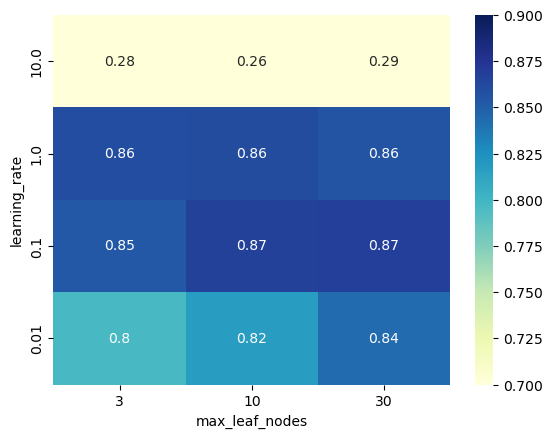

In [9]:
ax = sns.heatmap(
    pivoted_cv_results, annot=True, cmap="YlGnBu", vmin=0.7, vmax=0.9
)
ax.invert_yaxis()